# Electron Tag and Probe Study

Loading a NanoAOD dataset is very easy, you just have to know the name of the dataset. Availability of the __dasgoclient__ is required.

In [1]:
from geeksw.nanocache import load_dataset

In [2]:
dataset = load_dataset("/SingleElectron/Run2017B-Nano14Dec2018-v1/NANOAOD")

Let's import some other things we need for the study:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

The way nanocache handles the datasets internally is inspired by uproot. That means it also implements the `keys()` and `allkeys()` methods to see what is in the files:

In [4]:
dataset.keys()

[b'tag;1',
 b'Events;1',
 b'LuminosityBlocks;1',
 b'Runs;1',
 b'MetaData;1',
 b'ParameterSets;1']

We can access individual object like the event tree like items in a dictionary:

In [5]:
events = dataset["Events"]

Again, we investigate the tree content with `keys()`. Let's restrict ourselves to the electron variables however:

In [6]:
for name in events.keys():
    if "Electron" in name:
        print(name)

nElectron
Electron_deltaEtaSC
Electron_dr03EcalRecHitSumEt
Electron_dr03HcalDepth1TowerSumEt
Electron_dr03TkSumPt
Electron_dr03TkSumPtHEEP
Electron_dxy
Electron_dxyErr
Electron_dz
Electron_dzErr
Electron_eCorr
Electron_eInvMinusPInv
Electron_energyErr
Electron_eta
Electron_hoe
Electron_ip3d
Electron_jetRelIso
Electron_mass
Electron_miniPFRelIso_all
Electron_miniPFRelIso_chg
Electron_mvaFall17V1Iso
Electron_mvaFall17V1noIso
Electron_mvaFall17V2Iso
Electron_mvaFall17V2noIso
Electron_pfRelIso03_all
Electron_pfRelIso03_chg
Electron_phi
Electron_pt
Electron_r9
Electron_sieie
Electron_sip3d
Electron_mvaTTH
Electron_charge
Electron_cutBased
Electron_cutBased_Fall17_V1
Electron_jetIdx
Electron_pdgId
Electron_photonIdx
Electron_tightCharge
Electron_vidNestedWPBitmap
Electron_convVeto
Electron_cutBased_HEEP
Electron_isPFcand
Electron_lostHits
Electron_mvaFall17V1Iso_WP80
Electron_mvaFall17V1Iso_WP90
Electron_mvaFall17V1Iso_WPL
Electron_mvaFall17V1noIso_WP80
Electron_mvaFall17V1noIso_WP90
Electro

This is quite some information at our fingertips! Let's load the $p_T$ of all electrons in this data run:

In [7]:
%%time
ele_pt = events.array("Electron_pt")
print("Number of events: "+ str(len(ele_pt)))
print("Number of electrons: "+ str(len(ele_pt.flatten())))

Getting from cache /SingleElectron/Run2017B-Nano14Dec2018-v1/NANOAOD/Events/Electron_pt...
Number of events: 60537490
Number of electrons: 67306773
CPU times: user 2.8 s, sys: 1.25 s, total: 4.05 s
Wall time: 4.05 s


Great, we loaded the electron $p_T$ of about 10 % of all data taken in Run 2 into memory in just about 3 seconds. Of course, the branch loaded only so fast because I already used it once before. That's why it is cached on `/scratch`.

If the branch would not have been already cached, it would have been fetched over the grid via xrootd, reading all ROOT files of the dataset individually and merging the arrays. This was the time measurement when it was done the first time:

```
CPU times: user 1min 23s, sys: 5.73 s, total: 1min 29s
Wall time: 3min 53s
```

Note that the total time was lower than the wall time, which is because nanocache reads the files in multiple threads.

Let's make a histogram now:

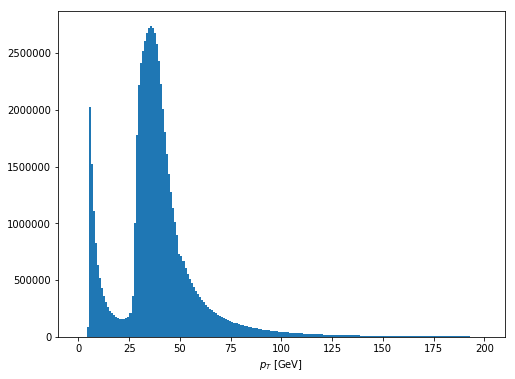

CPU times: user 7.18 s, sys: 4.91 s, total: 12.1 s
Wall time: 4.66 s


In [8]:
%%time
bins = np.linspace(0, 200, 200)
plt.figure(figsize=(8,6))
plt.hist(ele_pt.flatten(), bins=bins)
plt.xlabel(r"$p_T$ [GeV]")
plt.show()

Plotting histograms is not the fastest operation, but with only 6 seconds this is still very much interactive.

Before we can start doing some serious work, we have to load some more branches:

In [9]:
ele_eta = events.array("Electron_eta")
ele_phi = events.array("Electron_phi")
ele_charge = events.array("Electron_charge")
ele_mass = events.array("Electron_mass")
ele_cutBased = events.array("Electron_cutBased")
ele_mvaWP = events.array("Electron_mvaFall17V2Iso_WP90")

Getting from cache /SingleElectron/Run2017B-Nano14Dec2018-v1/NANOAOD/Events/Electron_eta...
Getting from cache /SingleElectron/Run2017B-Nano14Dec2018-v1/NANOAOD/Events/Electron_phi...
Getting from cache /SingleElectron/Run2017B-Nano14Dec2018-v1/NANOAOD/Events/Electron_charge...
Getting from cache /SingleElectron/Run2017B-Nano14Dec2018-v1/NANOAOD/Events/Electron_mass...
Getting from cache /SingleElectron/Run2017B-Nano14Dec2018-v1/NANOAOD/Events/Electron_cutBased...
Getting from cache /SingleElectron/Run2017B-Nano14Dec2018-v1/NANOAOD/Events/Electron_mvaFall17V2Iso_WP90...


Now it's time to import [uproot-methods](https://github.com/scikit-hep/uproot-methods), which reimplements in Python the classes wich are actually useful from ROOT and adapts them to columnar data analysis

In [10]:
import uproot_methods

The highlight for us there is the `TLorentVectorArray`, which implements an array of the `TLorentzVectors` we know from ROOT. We construct it from the data we loaded:

In [11]:
electrons = uproot_methods.TLorentzVectorArray.from_ptetaphim(ele_pt,
                                                              ele_eta,
                                                              ele_phi,
                                                              ele_mass)

In fakt, the `TLorentzVectorArray` inherits from the `table` class in awkward, so we can all other columns easily:

In [12]:
electrons["mvaWP"] = ele_mvaWP
electrons["charge"] = ele_charge
electrons["cutBased"] = ele_cutBased

We use this electrons structure to easily select the tag electrons. `cutBased == 4` means here passing the tight cut ID, which means this electron must have also been the triggering one in order to not bias the probes. In other words, one can't use whatever ID for the tag selection. Additionally, there are some $\eta$ and $p_T$ requirements to ensure we have basically no fake tags.

In [13]:
%%time
tag_selection = np.logical_and(electrons["cutBased"] == 4,
                               np.logical_and(electrons.pt > 30, np.abs(electrons.eta) < 2.17))
tags = electrons[tag_selection]

CPU times: user 13.8 s, sys: 9.57 s, total: 23.4 s
Wall time: 23.5 s


Wow that took quite some time! There is no free lunch it seems. What do we do when there it more than one tag per event? Let's take the one with the higher $p_T$. The JaggedArray implements the very handy `argmax` function for this purpose.

In [14]:
%%time
tags = tags[tags.pt.argmax()]

CPU times: user 54 s, sys: 4.35 s, total: 58.3 s
Wall time: 58.5 s


Up to select the probes! Let's select as much as possible so the later combinatorics operation will be as cheap as possible. First, let's discard the events which have no tags.

In [15]:
probes = electrons[tags.counts > 0]
tags = tags[tags.counts > 0]

Of course the probe has to be of opposite sign. This also cleans the probes of the tags.

In [16]:
probes = probes[probes["charge"] != tags["charge"].flatten()]

Now, magic time! We combine the tags with the probes in all combinations per event with the `cross` function:

In [17]:
%%time
pairs = tags.cross(probes)

CPU times: user 2.04 s, sys: 701 ms, total: 2.75 s
Wall time: 2.75 s


That was quicker than expected actually! One step that is done in egamma but I __won't do__ here is to arbitrate such that only one pair per event is choosen. This would however bias the kinematic phasespace of the tag (for example by selecting the pair with the highest $p_T$), which I don't want to do.

So we are basically done here! Let's just calculate the pair masses.

In [18]:
pair_mass = (pairs.i0 + pairs.i1).mass

/home/llr/cms/rembser/.local/lib/python3.7/site-packages/uproot_methods/classes/TLorentzVector.py:192: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


We are now at a point where we don't need the event structure anymore. Let's flatten the probes and pair masses.

In [19]:
probes = probes.flatten()
pair_mass = pair_mass.flatten()

We are now done with the steps which would be traditionally done in C++ with CMSSW. We are now ready to do everything in the flat structure, so we can put everything in a pandas DataFrame and study the probes like int the egamma TnP fitter tool.

In [20]:
import pandas as pd

In [21]:
probes = pd.DataFrame(data={
    "pt" : probes.pt,
    "eta" : probes.eta,
    "phi" : probes.phi,
    "mass" : probes.mass,
    "charge" : probes["charge"],
    "mvaWP" : probes["mvaWP"],
    "cutBased" : probes["cutBased"],
    "pair_mass" : pair_mass
})

Pandas users should feel right at home now!

In [22]:
probes.head()

,pt,eta,phi,mass,charge,mvaWP,cutBased,pair_mass
0,23.889467,1.530518,-2.213867,-0.011604,-1,True,4,89.398796
1,36.328728,-1.412842,-2.108887,-0.022079,-1,False,2,95.481018
2,41.168594,-0.544067,-0.783081,0.007423,-1,True,4,91.523064
3,22.344339,-1.438965,0.404724,0.016418,1,True,4,91.623528
4,39.002842,-0.472229,-3.016113,0.004730,1,True,4,92.517242


Let's finish this example by saving this table to a file. You can move on to the fitter example notebook to see how we move on to a first data driven efficiency measurement!

Define the binning in $p_T$ and $\eta$, as in the egamma tool.

In [23]:
eta_bins = np.array([0.0, 0.8, 1.5, 2.0, 2.5])
pt_bins = np.array([20,35,50,100,200])

We don't want to loose much time doing the binning, so we try to do it in an efficient way. We figure out the $\eta$ and $p_T$ bins separately and then encode them in bin indices.

In [24]:
probes["eta_bin"] = np.digitize(np.abs(probes["eta"]), eta_bins)
probes["pt_bin"] = np.digitize(probes["pt"], pt_bins)

In [25]:
probes.head()

,pt,eta,phi,mass,charge,mvaWP,cutBased,pair_mass,eta_bin,pt_bin
0,23.889467,1.530518,-2.213867,-0.011604,-1,True,4,89.398796,3,1
1,36.328728,-1.412842,-2.108887,-0.022079,-1,False,2,95.481018,2,2
2,41.168594,-0.544067,-0.783081,0.007423,-1,True,4,91.523064,1,2
3,22.344339,-1.438965,0.404724,0.016418,1,True,4,91.623528,2,1
4,39.002842,-0.472229,-3.016113,0.004730,1,True,4,92.517242,1,2


Let's only select the probes with are in the range of the bins:

In [26]:
probes = probes.query(f"0 < eta_bin < {len(eta_bins)} and 0 < pt_bin < {len(pt_bins)}").copy()

Now we encode to a bin index and sort the probes by the bin to make some order:

In [27]:
probes["bin"] = probes["eta_bin"] - 1 + (probes["pt_bin"] - 1) * len(eta_bins)
probes = probes.sort_values("bin")

Time to plot! We define some mass bins and a function to plot a histogram, and then plot passing and failing probes in a bin as an example.

In [28]:
mass_bins = np.linspace(60, 120, 61)

We import `curve_fit` from scipy and some predefined probability distributions from geeksw:

In [33]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from geeksw.fitting.functions import cmsshape, cbexgaus

In [34]:
def plot_hist(x, bins=None):
    h, bin_edges = np.histogram(x, bins=bins)
    h_err = np.sqrt(h)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

    sigma = np.copy(h_err)
    sigma[sigma == 0] = 1 # placeholder for the uncertainty on zero counts
    popt, pcov = curve_fit(fit_func, bin_centers, h, sigma=sigma, p0=p0)

    plt.errorbar(bin_centers, h, yerr=h_err, color='k', fmt='o')
    plt.plot(bin_centers, fit_func(bin_centers, *popt), color='r')

Let's not bother about the fitting funciton too much in this example. An exponential for the background plus a Gaussian for the signal should be enough for now (highly inadequate by the way).

In [35]:
def fit_func(x, acms, beta, gamma, peak, m0, sigma, alpha, n, sigma2, left_tail, A1, A2):
    bkg = A1 * cmsshape(x, acms, beta, gamma, peak)
    sig = A2 * cbexgaus(x, m0, sigma, alpha, n, sigma2, left_tail)
    return bkg + sig

p0 = [60, 0.05, 0.1, 90,     90.,1.,2.,3.,1.5,1,   100, 100]

We make the plots for the first bin:

/home/llr/cms/rembser/.local/lib/python3.7/site-packages/geeksw/fitting/functions.py:81: RuntimeWarning: overflow encountered in exp
  return (u < -70) * e*1e20 + np.logical_and(u >= -70, u <= 70) * e*np.exp(-u)
/home/llr/cms/rembser/.local/lib/python3.7/site-packages/geeksw/fitting/functions.py:81: RuntimeWarning: invalid value encountered in multiply
  return (u < -70) * e*1e20 + np.logical_and(u >= -70, u <= 70) * e*np.exp(-u)
/home/llr/cms/rembser/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


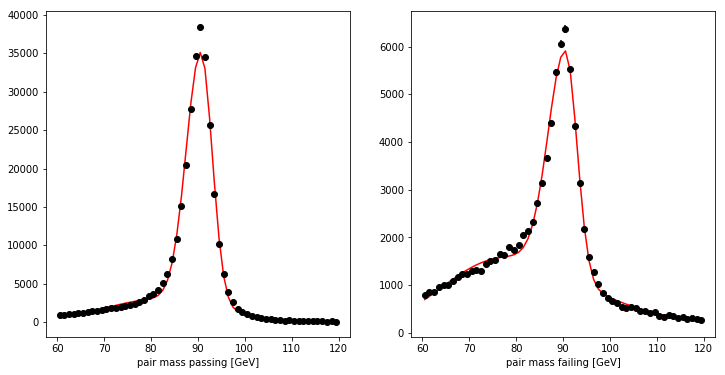

In [36]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.xlabel(r"pair mass passing [GeV]")
plot_hist(probes.query("bin == 0 and mvaWP").pair_mass, bins=mass_bins)
plt.subplot(1, 2, 2)
plt.xlabel(r"pair mass failing [GeV]")
plot_hist(probes.query("bin == 0 and not mvaWP").pair_mass, bins=mass_bins)
plt.show()

However, we want to get the efficiency and uncertainty for every bin, so let's write a function to just extract this. The efficiency will be the ratio of the scales of the fitted Gaussians and the uncertainty the propagated covariances on this paramter.

In [48]:
def get_signal_amplitude(probes):
    h, bin_edges = np.histogram(probes.pair_mass, bins=mass_bins)
    h_err = np.sqrt(h)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

    sigma = np.copy(h_err)
    sigma[sigma == 0] = 1 # placeholder for the uncertainty on zero counts

    try:
        popt, pcov = curve_fit(fit_func, bin_centers, h, sigma=sigma, p0=p0)
    except RuntimeError:
        popt = np.ones_like(p0) * np.nan
        pcov = np.ones((len(p0),len(p0))) * np.nan
    return pd.Series({"amplitude":popt[2], "amplitude_uncert":np.sqrt(pcov[2,2])})


We calculate the amplitudes for passing and failing and merge the resulting data frames such that we can continue easily.

In [49]:
passing_amplitudes = probes.query("mvaWP").groupby("bin").apply(get_signal_amplitude)
failing_amplitudes = probes.query("not mvaWP").groupby("bin").apply(get_signal_amplitude)

In [50]:
df = passing_amplitudes.join(failing_amplitudes, lsuffix="_passing", rsuffix="_failing")

In [55]:
df.head()

,amplitude_passing,amplitude_uncert_passing,amplitude_failing,amplitude_uncert_failing,efficiency,efficiency_uncert
bin,,,,,,
0,0.828658,inf,0.061153,inf,0.931275,inf
1,0.825967,inf,0.052171,inf,0.940589,inf
2,0.193922,inf,0.046703,inf,0.805911,inf
3,0.321010,inf,0.049959,inf,0.865327,inf
5,0.179703,inf,0.093452,inf,0.657880,inf


Looks good! Last we calculate the actual efficiency and uncertainty.

In [56]:
df = df.eval("efficiency = amplitude_passing / (amplitude_passing + amplitude_failing)")
df = df.eval("efficiency_uncert = sqrt(amplitude_uncert_passing**2 + amplitude_uncert_failing**2) \
             / (amplitude_passing + amplitude_failing)")

Almost there! The efficiencies are calculated, we just need to associate them to the right $p_T$ and $\eta$ ranges and make a plot.

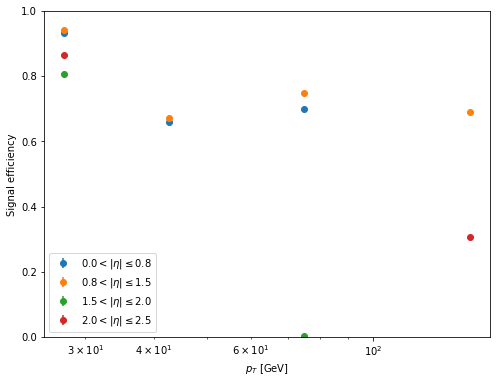

In [57]:
pt_bin_centers = (pt_bins[:-1] + pt_bins[1:])/2.

plt.figure(figsize=(8,6))
for i in range(len(eta_bins)-1):
    plt.errorbar(pt_bin_centers,
                 df["efficiency"].values[i::len(eta_bins)-1],
                 yerr=df["efficiency_uncert"].values[i::len(eta_bins)-1],
                 fmt="o", label=r"${0} < |\eta| \leq {1}$".format(eta_bins[i],eta_bins[i+1])
                )
plt.ylabel("Signal efficiency")
plt.xlabel(r"$p_T$ [GeV]")
plt.gca().set_xscale("log")
plt.legend(loc="lower left")
plt.ylim(0,1)
plt.show()

Well, one can see that the working point we study here was indeed supposed to be about 90 % efficient. However, the inadequate fitting function does not give good results for higher energies. Anyway this was just a proof of concept and it is left to the reader to improve the efficiency measuruement with better fits.